In [3]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
import sys, os
sys.path.append(os.path.abspath("../scripts"))

from load_and_explore import load_json
from flatten_extract import flatten_all
from edge_case_handler import handle_missing
from compute_metrics import compute_metrics


In [4]:
data = load_json("../data/shipments.json")

print("Total shipment records:", len(data))
pprint(list(data[0].keys()))


Total shipment records: 99
['highestSeverity',
 'notifications',
 'duplicateWaybill',
 'moreData',
 'trackDetailsCount',
 'trackDetails']


In [5]:
sample = data[0]["trackDetails"][0]
pprint(sample.keys())

print("\nEvent count:", len(sample.get("events", [])))


dict_keys(['notification', 'trackingNumber', 'trackingNumberUniqueIdentifier', 'statusDetail', 'informationNotes', 'customerExceptionRequests', 'carrierCode', 'operatingCompanyOrCarrierDescription', 'otherIdentifiers', 'service', 'packageWeight', 'shipmentWeight', 'packaging', 'packageSequenceNumber', 'packageCount', 'shipmentContentPieceCount', 'packageContentPieceCount', 'creatorSoftwareId', 'charges', 'attributes', 'shipmentContents', 'packageContents', 'commodities', 'customsOptionDetails', 'specialHandlings', 'payments', 'shipperAddress', 'datesOrTimes', 'specialInstructions', 'lastUpdatedDestinationAddress', 'destinationAddress', 'actualDeliveryAddress', 'deliveryLocationType', 'deliveryLocationDescription', 'deliveryAttempts', 'deliverySignatureName', 'pieceCountVerificationDetails', 'totalUniqueAddressCountInConsolidation', 'availableImages', 'notificationEventsAvailable', 'splitShipmentParts', 'deliveryOptionEligibilityDetails', 'events'])

Event count: 11


In [6]:
events = sample.get("events", [])
for e in events[:5]:
    pprint(e)
    print("-"*60)


{'address': {'city': 'Gurgaon',
             'countryCode': 'IN',
             'countryName': 'India',
             'postalCode': '122001',
             'residential': False,
             'stateOrProvinceCode': 'HR',
             'streetLines': []},
 'arrivalLocation': 'DELIVERY_LOCATION',
 'eventDescription': 'Delivered',
 'eventType': 'DL',
 'statusExceptionCode': '11',
 'statusExceptionDescription': 'C.O.D. payment received',
 'timestamp': {'$numberLong': '1584691620000'}}
------------------------------------------------------------
{'address': {'city': 'MANESAR',
             'countryCode': 'IN',
             'countryName': 'India',
             'postalCode': '122050',
             'residential': False,
             'stateOrProvinceCode': 'HR',
             'streetLines': []},
 'arrivalLocation': 'VEHICLE',
 'eventDescription': 'On FedEx vehicle for delivery',
 'eventType': 'OD',
 'timestamp': {'$numberLong': '1584679560000'}}
-------------------------------------------------------

In [7]:
base_df, events_df = flatten_all(data)

print("Base DF shape:", base_df.shape)
print("Events DF shape:", events_df.shape)

base_df.head()


Base DF shape: (99, 13)
Events DF shape: (1240, 8)


,tracking_number,service_type,service_description,carrier_code,package_weight,package_weight_units,packaging_type,origin_city,origin_state,origin_pincode,destination_city,destination_state,destination_pincode
0,391128701026,FEDEX_EXPRESS_SAVER,FedEx Economy,FDXE,14.0,KG,YOUR_PACKAGING,Bangalore,KA,None,Gurgaon,HR,None
1,390901883808,FEDEX_EXPRESS_SAVER,FedEx Economy,FDXE,14.0,KG,YOUR_PACKAGING,Bangalore,KA,None,Bangalore,KA,None
2,391128749178,FEDEX_EXPRESS_SAVER,FedEx Economy,FDXE,14.0,KG,YOUR_PACKAGING,Bangalore,KA,None,Ahmedabad,GJ,None
3,390807986805,FEDEX_EXPRESS_SAVER,FedEx Economy,FDXE,14.0,KG,YOUR_PACKAGING,Bangalore,KA,None,New Delhi,DL,None
4,390948921190,FEDEX_EXPRESS_SAVER,FedEx Economy,FDXE,14.0,KG,YOUR_PACKAGING,Bangalore,KA,None,Delhi,DL,None


In [8]:
events_df.head()


,tracking_number,event_type,event_description,event_timestamp,event_city,event_state,event_pincode,arrival_location
0,391128701026,DL,Delivered,2020-03-20 13:37:00+05:30,Gurgaon,HR,122001,DELIVERY_LOCATION
1,391128701026,OD,On FedEx vehicle for delivery,2020-03-20 10:16:00+05:30,MANESAR,HR,122050,VEHICLE
2,391128701026,IT,In transit,2020-03-20 09:18:00+05:30,GURGAON,HR,122001,FEDEX_FACILITY
3,391128701026,AR,At local FedEx facility,2020-03-20 08:46:00+05:30,MANESAR,HR,122050,DESTINATION_FEDEX_FACILITY
4,391128701026,IT,In transit,2020-03-20 01:04:00+05:30,GURGAON,HR,122001,FEDEX_FACILITY


In [9]:
event_counts = events_df["event_type"].value_counts()
event_counts


event_type
IT    534
AR    166
DL     99
PU     99
OC     99
OD     96
DP     84
DE     42
AF     19
SE      1
AS      1
Name: count, dtype: int64

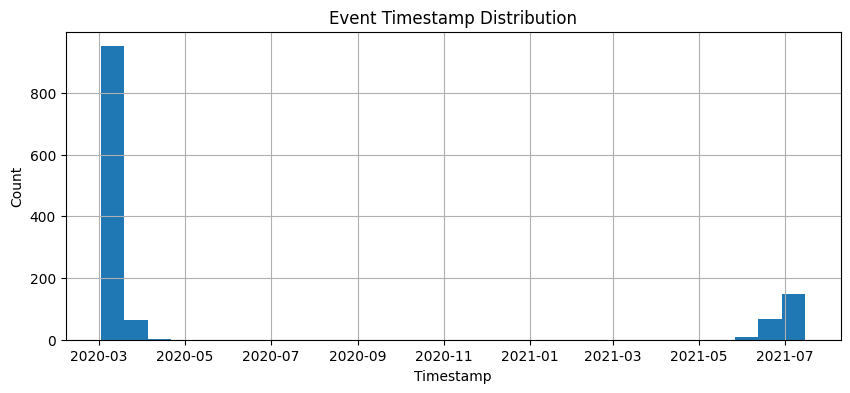

In [10]:
events_df["event_timestamp"].hist(bins=30, figsize=(10,4))
plt.title("Event Timestamp Distribution")
plt.xlabel("Timestamp")
plt.ylabel("Count")
plt.show()


In [11]:
base_df, events_df = handle_missing(base_df, events_df)


In [12]:
metrics_df = compute_metrics(base_df, events_df)
metrics_df.head()


,tracking_number,pickup_datetime_ist,delivery_datetime_ist,total_transit_hours,num_facilities_visited,num_in_transit_events,avg_hours_per_facility,num_out_for_delivery_attempts,first_attempt_delivery,total_events_count,unique_event_types_count
0,280267328981,2021-06-11 18:56:00+05:30,2021-06-18 17:18:00+05:30,166.366667,4,9,41.591667,0,False,16,7
1,280267329094,2021-06-11 18:56:00+05:30,2021-06-16 11:28:00+05:30,112.533333,3,7,37.511111,0,False,18,8
2,280307632740,2021-06-14 19:31:00+05:30,2021-06-16 16:30:00+05:30,44.983333,3,4,14.994444,1,True,11,8
3,280307633276,2021-06-14 19:31:00+05:30,2021-06-16 16:30:00+05:30,44.983333,3,4,14.994444,1,True,11,8
4,280439181099,2021-06-16 19:22:00+05:30,2021-06-24 18:22:00+05:30,191.000000,4,6,47.750000,1,True,17,9


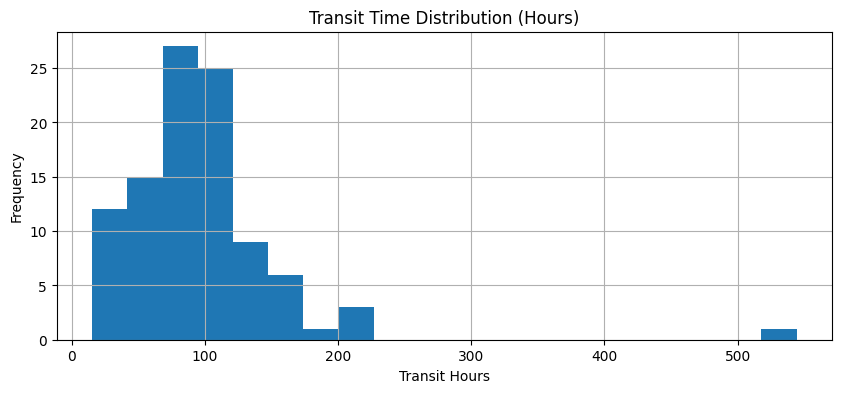

In [13]:
metrics_df["total_transit_hours"].hist(bins=20, figsize=(10,4))
plt.title("Transit Time Distribution (Hours)")
plt.xlabel("Transit Hours")
plt.ylabel("Frequency")
plt.show()


In [14]:
final_df = base_df.merge(metrics_df, on="tracking_number", how="left")
final_df.head()


,tracking_number,service_type,service_description,carrier_code,package_weight,package_weight_units,packaging_type,origin_city,origin_state,origin_pincode,...,pickup_datetime_ist,delivery_datetime_ist,total_transit_hours,num_facilities_visited,num_in_transit_events,avg_hours_per_facility,num_out_for_delivery_attempts,first_attempt_delivery,total_events_count,unique_event_types_count
0,391128701026,FEDEX_EXPRESS_SAVER,FedEx Economy,FDXE,14.0,KG,YOUR_PACKAGING,Bangalore,KA,None,...,2020-03-16 15:44:00+05:30,2020-03-20 13:37:00+05:30,93.883333,3,5,31.294444,1,True,11,7
1,390901883808,FEDEX_EXPRESS_SAVER,FedEx Economy,FDXE,14.0,KG,YOUR_PACKAGING,Bangalore,KA,None,...,2020-03-06 16:07:00+05:30,2020-03-09 19:50:00+05:30,75.716667,1,5,75.716667,2,False,12,7
2,391128749178,FEDEX_EXPRESS_SAVER,FedEx Economy,FDXE,14.0,KG,YOUR_PACKAGING,Bangalore,KA,None,...,2020-03-16 15:44:00+05:30,2020-03-19 15:29:00+05:30,71.750000,3,6,23.916667,1,True,12,7
3,390807986805,FEDEX_EXPRESS_SAVER,FedEx Economy,FDXE,14.0,KG,YOUR_PACKAGING,Bangalore,KA,None,...,2020-03-03 16:19:00+05:30,2020-03-07 14:24:00+05:30,94.083333,3,5,31.361111,1,True,10,6
4,390948921190,FEDEX_EXPRESS_SAVER,FedEx Economy,FDXE,14.0,KG,YOUR_PACKAGING,Bangalore,KA,None,...,2020-03-09 15:12:00+05:30,2020-03-13 14:44:00+05:30,95.533333,3,5,31.844444,1,True,11,7
